In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from astropy import units as u
from astropy.coordinates import EarthLocation, SkyCoord
from astropy.time import Time

from astroplan.plots import plot_airmass, plot_sky, plot_sky_24hr, plot_finder_image
from matplotlib import pyplot as plt
%matplotlib inline

from astroplan import Observer

from pocs.scheduler.dispatch import Scheduler
from pocs.scheduler.constraint import Duration, MoonAvoidance
from pocs.utils.config import load_config
from pocs.utils import listify

config = load_config()

In [3]:
# Get a location
loc = config['location']
location = EarthLocation(lon=loc['longitude'], lat=loc['latitude'], height=loc['elevation'])

# Get an observer at the location
observer = Observer(location=location)

# Get the night hours (you can use observer.tonight())
times = observer.tonight(horizon=-18 * u.degree)
start_of_night = times[0]
end_of_night = times[1]
# start_of_night = Time('2016-08-13 10:00:00')
# end_of_night = Time('2016-08-13 16:00:00')

In [4]:
simple_fields_file = config['directories']['targets'] + '/simple.yaml'

# Simple constraint to maximize duration above a certain altitude
constraints = [MoonAvoidance(), Duration(30 * u.deg)]

# Create a scheduler
scheduler = Scheduler(observer, fields_file=simple_fields_file, constraints=constraints)

{'name': 'Kepler 1100', 'priority': 125, 'position': '19h27m29.10s +44d05m15.00s'}
{'name': 'KIC 8462852', 'priority': 100, 'position': '20h06m15.4536s +44d27m24.75s'}
{'name': 'HD 189733', 'priority': 100, 'position': '20h00m43.7135s +22d42m39.0645s'}
{'name': 'HD 209458', 'priority': 100, 'position': '22h03m10.7721s +18d53m03.543s'}
{'name': 'Wasp 33', 'priority': 100, 'position': '02h26m51.0582s +37d33m01.733s'}
{'name': 'Tres 3', 'priority': 100, 'position': '17h52m07.02s +37d32m46.2012s'}
{'name': 'M42', 'priority': 75, 'position': '05h35m17.2992s -05d23m27.996s', 'exp_time': 240}
{'name': 'M44', 'priority': 50, 'position': '08h40m24s +19d40m00.12s'}
{'name': 'M5', 'priority': 50, 'position': '15h18m33.2201s +02d04m51.7008s'}


In [24]:
for obs in scheduler.observations.values():
    print(obs)

M42: 240.0 s exposures in blocks of 10, minimum 60, priority 75
Tres 3: 120.0 s exposures in blocks of 10, minimum 60, priority 100
HD 209458: 120.0 s exposures in blocks of 10, minimum 60, priority 100
M44: 120.0 s exposures in blocks of 10, minimum 60, priority 50
M5: 120.0 s exposures in blocks of 10, minimum 60, priority 50
KIC 8462852: 120.0 s exposures in blocks of 10, minimum 60, priority 100
Wasp 33: 120.0 s exposures in blocks of 10, minimum 60, priority 100
Kepler 1100: 120.0 s exposures in blocks of 10, minimum 60, priority 125
HD 189733: 120.0 s exposures in blocks of 10, minimum 60, priority 100


In [25]:
# Get the best observations for the given time
# show_all returns entire list along with merit
best = scheduler.get_observation(time=start_of_night, show_all=True)

for b in listify(best):
    print("Field: {:12s} Merit: {}".format(b[0], b[1]))

2016-08-25 16:29:00 ganymede panoptes[21834] INFO Setting new observation to HD 209458: 120.0 s exposures in blocks of 10, minimum 60, priority 100


Field: HD 209458    Merit: 102.43549231394323
Field: Tres 3       Merit: 102.15081096831756


In [26]:
scheduler.current_observation.field.coord.equinox

'J2000'

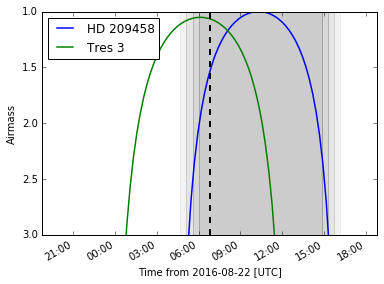

In [17]:
plot_airmass([scheduler.observations[name].field for name, merit in best], 
             scheduler.observer, start_of_night, 
             brightness_shading=True)
        
plt.axvline(start_of_night.plot_date, lw=2, ls='--', c='k')    
plt.legend(loc=2)
plt.show()

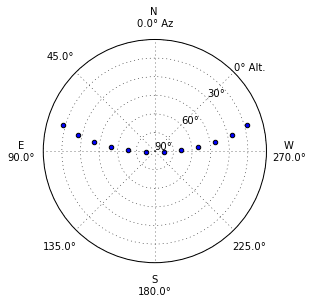

In [18]:
plot_sky_24hr(scheduler.current_observation.field, scheduler.observer, start_of_night)
plt.show()

In [19]:
# Set a later time to start
t2 = end_of_night - 3 * u.hour

# Get the best observation for the given time
# show_all returns entire list along with merit
best = scheduler.get_observation(show_all=True, time=t2)

for b in best:
    print("Field: {:12s} Merit: {}".format(b[0], b[1]))

2016-08-23 16:48:27 ganymede panoptes[11580] INFO Setting new observation to HD 209458: 120.0 s exposures in blocks of 10, minimum 60, priority 100


Field: HD 209458    Merit: 102.27218075907814
Field: Wasp 33      Merit: 102.15340312610776


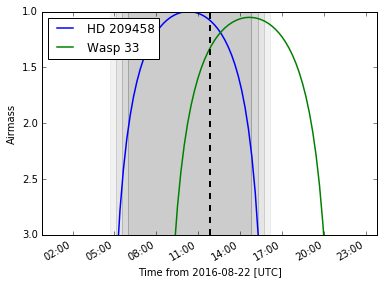

In [20]:
plot_airmass([scheduler.observations[name].field for name, merit in best], 
             scheduler.observer, t2, 
             brightness_shading=True)
plt.axvline(t2.plot_date, lw=2, ls='--', c='k')
plt.legend(loc=2)
plt.show()

## Entire Night Simulation

Now let's simulate going through the whole evening

In [21]:
# Start at the beginning of the night
next_time = start_of_night
print("Start of night at {}".format(start_of_night))

# Reset scheduler
# Create a scheduler
scheduler = Scheduler(simple_fields_file, observer, constraints=constraints)

while (next_time < end_of_night):    
    # Only get new target if we have met min_nexp for observation
    if (scheduler.current_observation is None) or \
        (scheduler.current_observation.current_exp >= scheduler.current_observation.min_nexp):
        
        print("Getting new observation at {}".format(next_time))
        new_obs = scheduler.get_observation(time=next_time)
        
    if scheduler.current_observation is not None:

        if (scheduler.current_observation.current_exp < scheduler.current_observation.min_nexp):
            obs_duration = scheduler.current_observation.minimum_duration

            # Fake the exposure count
            scheduler.current_observation.current_exp = scheduler.current_observation.min_nexp
        else:
            obs_duration = scheduler.current_observation.set_duration
            # Fake the exposure count
            scheduler.current_observation.current_exp += scheduler.current_observation.exp_set_size

        print("\tWill observe {} with merit of {:0.5f} for {}".format(
                    scheduler.current_observation.name, 
                    scheduler.current_observation.merit, 
                    obs_duration))
        print("\t{} of {}".format(scheduler.current_observation.current_exp, 
                                  scheduler.current_observation.min_nexp))
                
    next_time = next_time + obs_duration
    
print("End of night at {}".format(end_of_night.isot))

Start of night at 2016-08-23 06:47:09.242415
Getting new observation at 2016-08-23 06:47:09.242415


2016-08-23 16:48:42 ganymede panoptes[11580] INFO Setting new observation to HD 209458: 120.0 s exposures in blocks of 10, minimum 60, priority 100


	Will observe HD 209458 with merit of 102.31674 for 7200.0 s
	60 of 60
Getting new observation at 2016-08-23 08:47:09.242415


2016-08-23 16:48:49 ganymede panoptes[11580] INFO Setting new observation to Kepler 1100: 120.0 s exposures in blocks of 10, minimum 60, priority 125


	Will observe Kepler 1100 with merit of 127.07731 for 7200.0 s
	60 of 60
Getting new observation at 2016-08-23 10:47:09.242415


2016-08-23 16:48:55 ganymede panoptes[11580] INFO Setting new observation to HD 209458: 120.0 s exposures in blocks of 10, minimum 60, priority 100


	Will observe HD 209458 with merit of 102.29368 for 7200.0 s
	60 of 60
Getting new observation at 2016-08-23 12:47:09.242415
	Will observe HD 209458 with merit of 102.29368 for 1200.0 s
	70 of 60
Getting new observation at 2016-08-23 13:07:09.242415
	Will observe HD 209458 with merit of 102.29368 for 1200.0 s
	80 of 60
Getting new observation at 2016-08-23 13:27:09.242415
	Will observe HD 209458 with merit of 102.29368 for 1200.0 s
	90 of 60
Getting new observation at 2016-08-23 13:47:09.242415
	Will observe HD 209458 with merit of 102.29368 for 1200.0 s
	100 of 60
Getting new observation at 2016-08-23 14:07:09.242415
	Will observe HD 209458 with merit of 102.29368 for 1200.0 s
	110 of 60
Getting new observation at 2016-08-23 14:27:09.242415


2016-08-23 16:49:22 ganymede panoptes[11580] WARNING No valid observations found
2016-08-23 16:49:22 ganymede panoptes[11580] INFO Setting new observation to None


Getting new observation at 2016-08-23 14:47:09.242415
End of night at 2016-08-23T14:49:24.466


In [15]:
time = Time('2016-08-13 11:00:00')
scheduler.get_observation(time=time)
print(scheduler.current_observation)

time = Time('2016-08-13 13:00:00')
scheduler.get_observation(time=time)
print(scheduler.current_observation)

time = Time('2016-08-13 14:30:00')
scheduler.get_observation(time=time)
print(scheduler.current_observation)

2016-08-30 16:55:22 ganymede panoptes[2303] INFO Setting new observation to Wasp 33: 120.0 s exposures in blocks of 10, minimum 60, priority 100


Wasp 33: 120.0 s exposures in blocks of 10, minimum 60, priority 100
Wasp 33: 120.0 s exposures in blocks of 10, minimum 60, priority 100


2016-08-30 16:55:30 ganymede panoptes[2303] WARNING No valid observations found
2016-08-30 16:55:30 ganymede panoptes[2303] INFO Setting new observation to None


None


In [10]:
scheduler.current_observation 